# Modular Arithmetic with `hierarqcal`

In [1]:
# imports 

from hierarqcal import (
    Qcycle,
    Qmotif,
    Qinit,
    Qmask,
    Qunmask,
    Qpermute,
    Qpivot,
    plot_circuit,
    plot_motif,
    get_tensor_as_f,
    Qunitary,
    Qhierarchy,
)
import numpy as np
import sympy as sp
import itertools as it

### Motivation

Many classical and quantum algorithms rely heavily on subcircuits for modular arithmetic. While this is easily done in the classical case, it is not quite so simple for quantum algorithms. Remember that in quantum information, our operators are *unitary* and *Hermitian*, meaning that they obey the following relation:

$$ U = U^\dagger = U^{-1}$$

While this may look innocent, **don't be fooled**! It imposes some constraints that means we can't just naively copy and paste the corresponding classical algorithms.

But what are these constraints? Suppose we have some quantum state $\ket{\psi}$, and we apply some unitary operator $U$ to it. Clearly, we get some other state $\ket{\phi} = U\ket{\psi}$. But, if we apply the same unitary operator again, we recover our initial state $\ket{\psi}$! This is because of the properties of $U$: $U^2 \ket{\psi} = U^\dagger U \ket{\psi} = \ket{\psi} = U^{-1} U \ket{\psi} = \ket{\psi}$. 

What does this mean? Simply put, it means that any (unitary) operation we want to do on our quantum system must be **reversible**. So, when implementing modular arithmetic in quantum form, it means we have to think a bit harder about what to do.

But never fear, `hierarqcal` is here - let's build a quantum arithmetic machine from scratch together!

### Intuition: Classical Adders

To start, let's understand how classical adder circuits work. 

### Half Adder

Suppose we have two bits, $A$ and $B$. We can add them through the following circuit, which copies the input bits to make two pairs, and applies an $\text{XOR}$ gate to one pair and a $\text{AND}$ gate to the other pair.

![alt text](Half_Adder.png "Schematic of a Half Adder (Wikipedia)")

This half adder circuit returns two bits, $S$ ('sum') and $C$ ('carry'). To see that it works, we can look at the truth table below (try it out yourself to check!):

|  A   |  B   |  C   |  S   |
| ---- | ---- | ---- | ---- |
|  0   |  0   |  0   |  0   |
|  0   |  1   |  0   |  1   |
|  1   |  0   |  0   |  1   |
|  1   |  1   |  1   |  0   |

Great! However, there's just one problem... the half adder is great for adding single bits, but in practice we will want to add large numbers that are comprised of many bits. But never fear - we can do this like we learned in first grade - by adding the least significant bits first and then sequentially adding the next least significant bits, along with any carried values from the previous operations.

However, the half adder can only add two bits, not the required three (two regular bits and one carry bit). This motivates the development of the *full adder*.


### Full Adder

![alt text](Full_Adder.png "Schematic of a Fuller Adder (Wikipedia)")

Instead of taking two bits as input, the full adder takes *three* - $A$, $B$, and $C$ - where $C$ represents a carry bit from the previous operation. The full adder works similarly to the half adder, but with two $\text{XOR}$ gates, two $\text{AND}$ gates, and one $\text{OR}$ gate. The number of output bits remains the same, so our truth table now looks like the following:

|  A   |  B   |  $C_{\text{in}}$   |  $C_{\text{out}}$   |  S   |
| ---- | ---- | ---- | ---- | ---- |
|  0   |  0   |  0   |  0   |  0   |
|  0   |  0   |  1   |  0   |  1   |
|  0   |  1   |  0   |  0   |  1   |
|  0   |  1   |  1   |  1   |  0   |
|  1   |  0   |  0   |  0   |  1   |
|  1   |  0   |  1   |  1   |  0   |
|  1   |  1   |  0   |  1   |  0   |
|  1   |  1   |  1   |  1   |  1   |

### Quantum Adders: Building Blocks
*Quick note: if any of this is familiar/boring to you, feel free to skip ahead! Conversely, if you're new to quantum circuits and/or `hierarqcal`, check out our core tutorial in `examples/core_tutorial.ipynb`!*

Similarly to the classical case, our quantum adder will rely on two crucial operations: a *sum* operation and a *carry* operation.

1. Gates
   - Turns out we only need a few gates to make this happen: $NOT, CNOT, SWAP, \text{Toffoli}$, and $\text{Hadamard}$. With the exception of $\text{Hadamard}$, all of these are gates in classical computing as well.
2. Subcircuits for a (vanilla) qArithmetic algorithm
   - First, we'll build a *carry* circuit and a *sum* circuit.
   - Then, we'll construct a quantum adder circuit with these.
3. Building a *modular* qArithmetic algorithm

In [9]:
def get_bitlist(a, n):
    """
    Returns a list of bits of length n representing the integer a.
    """
    a_bits = [int(b) for b in bin(a)[2:]]
    a_bits = [0] * (n - len(a_bits)) + a_bits
    return a_bits

def get_results(result_tensor, bit_layout):
    result = "".join([str(bit[0]) for bit in np.where(result_tensor == 1)])
    # register_r = [bit for bit, label in zip(result, bit_layout) if label == "r"]
    # register_x = [bit for bit, label in zip(result, bit_layout) if label == "x"]
    register_a = [bit for bit, label in zip(result, bit_layout) if label == "a"]
    register_b = [bit for bit, label in zip(result, bit_layout) if label == "b"]
    register_bc = [bit for bit, label in zip(result, bit_layout) if label == "bc"]
    register_c = [bit for bit, label in zip(result, bit_layout) if label == "c"]
    register_n = [bit for bit, label in zip(result, bit_layout) if label == "N"]
    register_n1 = [bit for bit, label in zip(result, bit_layout) if label == "t1"]
    # print(f"r: {register_r}")
    # print(f"x: {register_x}")
    print(f"a: {register_a}")
    print(f"b: {register_b} + {register_bc}")
    print(f"c: {register_c}")
    print(f"n: {register_n}")
    print(f"t: {register_n1}")
    return result, register_a, register_b, register_c, register_n, register_n1

def get_tensors(N, n, a=None, b=None):
    ket0 = np.array([1, 0])
    ket1 = np.array([0, 1])
    # Get bits
    a_bits = get_bitlist(a, n) if a is not None else [0] * n
    b_bits = get_bitlist(b, n) if b is not None else [0] * n
    modn = get_bitlist(N, n)
    # r_bits = get_bitlist(r, n)
    # x_bits = get_bitlist(x, n)
    # add r and x
    # r_tensors = [ket0 if elem == 0 else ket1 for elem in r_bits[::-1]]
    # x_tensors = [ket0 if elem == 0 else ket1 for elem in x_bits[::-1]]
    # init a,b,c to 0
    abc_tensors = [
        ket0 if elem == 0 else ket1
        for triplet in zip([0] * n, a_bits[::-1], b_bits[::-1])
        for elem in triplet
    ]
    bc_tensor = [ket0]
    N_tensors = [ket0 if elem == 0 else ket1 for elem in modn[::-1]]
    t0_tensor = [ket0]
    tensors =  abc_tensors + bc_tensor + N_tensors + t0_tensor
    return tensors

N = 4 # the modulus 
a = 4 # the first number we want to add
b = 3 # the second number we want to add

n = 4 # number of bits we use to store t
print(f"a - {a}\nb - {b}\nN - {N}\n")
bit_layout = ["c", "a", "b"] * n + ["bc"] + ["N"] * n + ["t1"]
nq = len(bit_layout)
tensors = get_tensors(N, n, a=a, b=b)

mask_part = lambda part, inv=False: Qmask(
    "".join(
        [str((1 + inv) % 2) if b in part else str((0 + inv) % 2) for b in bit_layout]
    )
)

a - 4
b - 3
N - 4



### 1. Gates
First, let's build some quantum gates! *For a refresher on the objects used in hierarqcal, see `examples/core_tutorial.ipynb` or check out the docs.*

In [3]:
# === Building matrices === #
toffoli_m = np.identity(8)
toffoli_m[6, 6] = 0
toffoli_m[6, 7] = 1
toffoli_m[7, 6] = 1
toffoli_m[7, 7] = 0
cnot_m = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
h_m = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
swap_m = np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])
x_m = np.array([[0, 1], [1, 0]])

# === Making our matrices into gates in hierarqcal! === #
toffoli = Qunitary(get_tensor_as_f(toffoli_m), 0, 3)
cnot = Qunitary(get_tensor_as_f(cnot_m), 0, 2)
hadamard = Qunitary(get_tensor_as_f(h_m), 0, 1)
swap = Qunitary(get_tensor_as_f(swap_m), 0, 2)
x = Qunitary(get_tensor_as_f(x_m), 0, 1)

### 2. Subcircuits

Now that we have our gates, let's look at the carry and sum circuits a little more closely. We're going to follow a method inspired by the classical method of summing each digit at a time.

In [11]:
# === Carry and Sum === #

carry_motif = (
    Qinit(4)
    + Qmotif(E=[(1, 2, 3)], mapping=toffoli)
    + Qmotif(E=[(1, 2)], mapping=cnot)
    + Qmotif(E=[(0, 2, 3)], mapping=toffoli)
)

# Turn carry into a function to be able to reverse it easily
carry = lambda r: carry_motif if r == 1 else carry_motif.reverse()

sum = lambda r=1: Qinit(3) + Qpivot(
    "*1", merge_within="01", mapping=cnot, edge_order=[-1 * r]
)

# Verifying our results!
# plot_circuit(carry(1))
# plot_circuit(carry(-1))
# plot_circuit(sum(1))
# plot_circuit(sum(-1))
hierq = (
    Qinit(nq, tensors=tensors)
    + Qmotif(E=[(0, 1, 2,3)], mapping=carry(1))
)
result_tensor = hierq()

get_results(result_tensor, bit_layout)
del result_tensor

a: ['0', '0', '1', '0']
b: ['1', '1', '0', '0'] + ['0']
c: ['0', '0', '0', '0']
n: ['0', '0', '1', '0']
t: ['0']


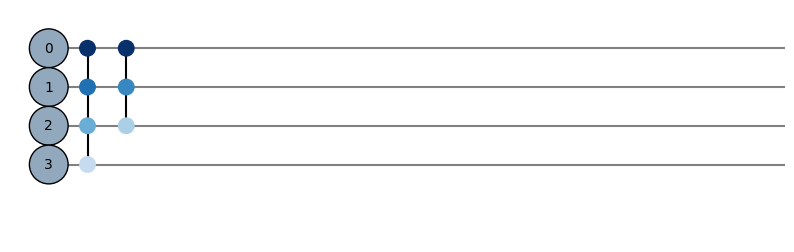

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

In [5]:
# === Making motifs from carry and sum === #
carry_sum_motif = (
    lambda r=1: Qinit(4)
    + Qpivot("1*", merge_within="1111", mapping=carry(-r))
    + Qpivot("1*", merge_within="111", mapping=sum(r))
)
carry_sum = lambda r=1: carry_sum_motif(1) if r == 1 else carry_sum_motif(-1).reverse()


cnot_sum_motif = (
    lambda r=1: Qinit(3)
    + Qpivot("*1", merge_within="11", mapping=cnot)
    + Qpivot("*1", merge_within="111", mapping=sum(r))
)
cnot_sum = lambda r=1: cnot_sum_motif(1) if r == 1 else cnot_sum_motif(-1).reverse()

plot_circuit(carry_sum(1))

In [6]:
# === A (vanilla) qArithmetic machine === #

carry_layer = lambda r=1: Qcycle(
    1,
    3,
    0,
    mapping=carry(r),
    boundary="open",
    edge_order=[r],
)

cnot_sum_pivot = lambda r: Qpivot("*10", merge_within="111", mapping=cnot_sum(r))
carry_sum_layer = lambda r: (
    Qmask("*111")
    + Qcycle(
        1,
        3,
        0,
        boundary="open",
        mapping=carry_sum(r),
        edge_order=[-r],
    )
    + Qunmask("previous")
)

addition = (
    mask_part(["N", "t1"], inv=False)
    + carry_layer(1)
    + cnot_sum_pivot(1)
    + carry_sum_layer(1)
    + Qunmask("previous")
)
subtraction = (
    mask_part([ "N", "t1"], inv=False)
    + carry_sum_layer(-1)
    + cnot_sum_pivot(-1)
    + carry_layer(-1)
    + Qunmask("previous")
)

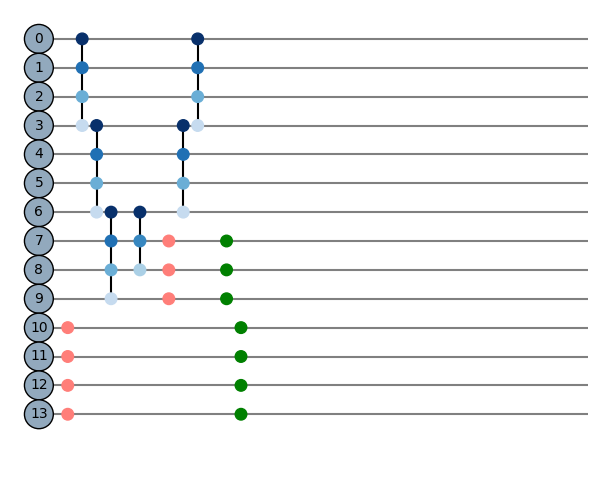

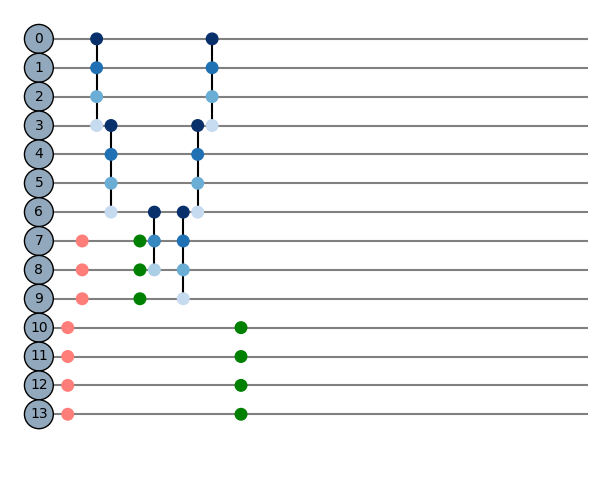

a: ['0', '0', '1']
b: ['1', '1', '1'] + ['0']
c: ['0', '0', '0']
n: ['0', '0', '1']
t: ['0']


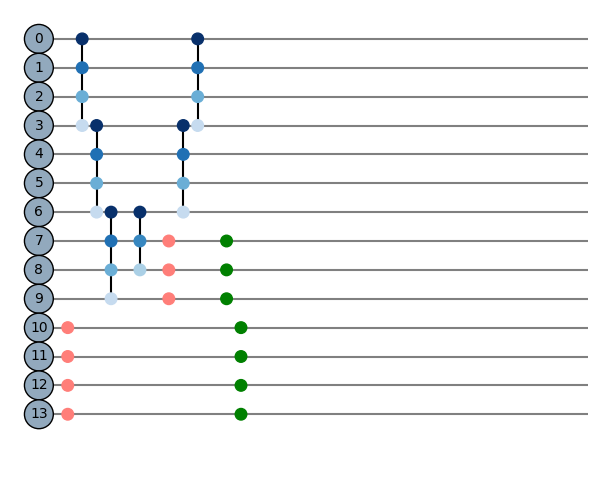

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

In [7]:
## Testing
plot_circuit(Qinit(nq)+addition)
plot_circuit(Qinit(nq)+subtraction)
hierq = (
    Qinit(nq, tensors=tensors)
    + addition
)
result_tensor = hierq()
get_results(result_tensor, bit_layout)
del result_tensor
plot_circuit(hierq)

### 3. Building a quantum modular arithmetic algorithm

Since we have a basic adder, now we can build one that does $\text{mod}~N$ addition. 

First, we'll make good use of the following fact: since $N>a,b$, we can easily see that $a+b < 2N~\forall a,b$. 

Therefore, all we need to do is add $a$ and $b$ and subtract $N$. If $a+b < N$ we should not perform the subtraction, luckily this information is encoded in the $b-carry$ ($b_c$) register ($b_c = 1$ if $a+b>N$, so we'll use that to decide whether we subtract N or not). 

We achieve this by swapping register $a$ and $N$. Then we use $t_1$ (temporary bit) to store whether $a+b>n~$(i.e. $b_c=1$). So we flip $b_c$, perform $CNOT$ onto $t_1$ and flip back. Now, we want to set all the ones of $N$ to 0 if $t_1 = 1$. This is done by masking all but register $a$ and $t_1$, then masking all the zeros of $N and finally pivot cnots controls onto $t_1$ where the targets cycle through the available bits of register $a$.

In [ ]:
# Build motif to swap a with N
swap_an = (
    mask_part(["a", "N"], inv=True)
    + Qcycle(n, 2, 0, mapping=swap, boundary="periodic")
    + Qunmask("previous")
)
# Build motif to flip temporary bit based on b carry
ctrl_not_bc_tmp_x = (
    mask_part(["bc", "t1"], inv=True)
    + Qpivot("10", mapping=x)
    + Qpivot("01", merge_within="01", mapping=cnot)
    + Qpivot("10", mapping=x)
    + Qunmask("previous")
)
# Build a motif that control flips the temporary bit without flipping bc
ctrl_not_bc_tmp = (
    mask_part(["bc", "t1"], inv=True)
    + Qpivot("01", merge_within="01", mapping=cnot)
    + Qunmask("previous")
)

# Build motif that sets "a" register to 0 if there wasn't an overflow
zeros_of_N = "".join([str((bit + 1) % 2) for bit in get_bitlist(N, n)])
reset_if_overflow = (
    mask_part(["a", "t1"], inv=True)
    + Qmask(zeros_of_N[::-1])
    + Qpivot(global_pattern="*1", merge_within="10", mapping=cnot)
    + Qunmask("previous")
    + Qunmask("previous")
)

In [ ]:
# here are our modular quantum arithmetic machines!
addition_mod_n = (
    addition
    + swap_an
    + subtraction
    + ctrl_not_bc_tmp_x
    + reset_if_overflow
    + addition
    + reset_if_overflow
    + swap_an
    + subtraction
    + ctrl_not_bc_tmp
    + addition
)

subtraction_mod_n = (
    subtraction
    + ctrl_not_bc_tmp
    + addition
    + swap_an
    + reset_if_overflow
    + subtraction
    + reset_if_overflow
    + ctrl_not_bc_tmp_x
    + addition
    + swap_an
    + subtraction
)

In [ ]:
# === verify
hierq = (
    Qinit(nq, tensors=tensors)
    + addition_mod_n
    #+ subtraction_mod_n
)
result_tensor = hierq()
get_results(result_tensor, bit_layout)
del result_tensor
plot_circuit(hierq, plot_width=100)